## Updates since last iteration:

### June 27 2022
* Includes a gridded color plot for virtual borehole
* Saves raw and filtered data in table
* Fixed bug in dataset testing
* Instead of just skipping poor quality data, we now save the data and the inverted results (as -999) to indicate data is presented but was not inverted


### May 13 2022
* Using better format for survey date/time
* Can extract resistivity at a specific point
* Can extract resistivity in a rectangular region
* Can plot a line plot for virtual borehole

## Import packages

In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import math
import sys
from ipywidgets import interact


## Load the data

In [2]:
# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')

n_data = 57
n_header = 3
n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))

# get electrodes

A = (elecs['A'].to_numpy())
B = (elecs['B'].to_numpy())
M = (elecs['M'].to_numpy())
N = (elecs['N'].to_numpy())

E = np.linspace(0,9.5,20) # positions


## Make a grid

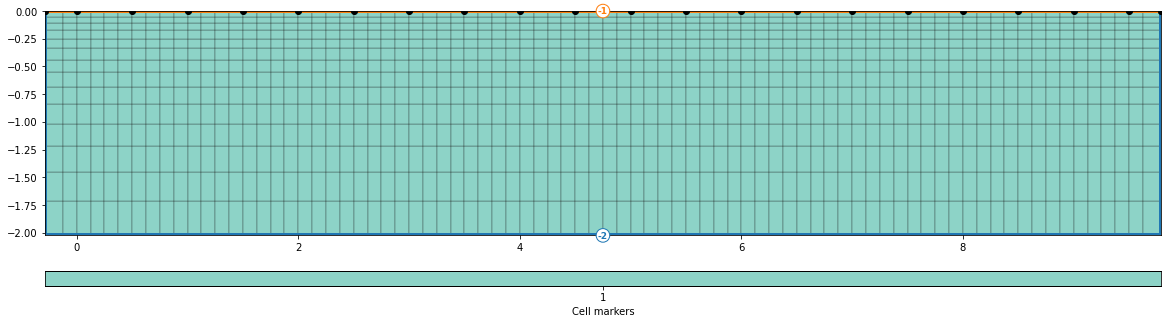

In [3]:
n_elec = len(E)
e_spc = E[1]-E[0] # assumes constant spacing for now
nb = 4 # number of cells between electrodes

# discretization in x-direction

hx = (np.ones((n_elec-1)*nb)*(e_spc/nb))
nxpad = 2
padx = (e_spc/nb)*1.3**(np.arange(0,nxpad,1))
xlocs = np.cumsum(np.hstack([0,np.flipud(padx), hx, padx]))-sum(padx)

# discretization in z-direction

pady = 0.05*1.15**(np.arange(0,14,1))
ylocs = np.flipud(-np.cumsum(np.hstack([0,pady])))

# make grid and plot

grid = pg.createGrid(
    x=xlocs,
    y=ylocs,
    marker=1, 
    worldBoundaryMarker=True
)

fig, ax = plt.subplots(figsize=[20,10])
pg.show(grid, markers=True,ax=ax,showMesh=True)

ax.plot(E,np.zeros(len(E)),'ko')


## Data processing function:

In [4]:
# data_raw = input raw data
# data_checked = checked for reciprocals/repeated measurements
# data_filt = filtered data (technical filter + moving median + electrode filter)
# data_out = dictionary of checked data with column for whether each data point was kept (used=1) or filtered (used=0)


In [5]:

def process_ERT_data(data_raw,survey_name,mesh,start_model,plotdata,plotmodel,plotmisfit):

    # thresholds:
    th_err = 10 # threshold for measurement error (%)
    th_std = 9 # removes data > 9*std(rhoa)
    th_mmf = 0.07 # threshold for moving median filter  TODO: make this higher for shallower data?
    th_elec_filt = 25 # threshold for determining bad electrode (%) - if more than x% data using an electrode are filtered, remove the rest
    th_bad_dataset = 30 # threshold for determining dataset quality (%) - if more than x% of all data points are removed, discard entire dataset

    
    # calculate geometric factor and apparent resistivity if not already in data file

    if data_raw.haveData('k')==False:
        if max(np.array(data.sensors()).T[2])-min(np.array(data.sensors()).T[2])==0: # is it flat?
            data_raw['k'] = ert.createGeometricFactors(data_raw) # no need for numerical solution
        else: # topography?
            data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation
            
    if data_raw.haveData('rhoa')==False:
        if data_raw.haveData('r')==False:
            data_raw['r'] = data_raw['u']/data_raw['i']
        data_raw['rhoa'] = data_raw['r']*data_raw['k'] 


    # put data into pandas dataframe

    df = pd.DataFrame(np.array(data_raw.dataMap(),dtype='object').T)
    header = df.iloc[0]
    df = df[1:] 
    df.columns = header
    df = df.apply(pd.Series.explode).reset_index(drop=True)

    df_raw = pd.DataFrame(df)
    df_raw['start_index'] = df_raw.index

    # look for reciprocal or repeated measurements

    src = np.stack([df_raw['a'],df_raw['b']]).T
    rec = np.stack([df_raw['m'],df_raw['n']]).T

    src_f = src[0]
    rec_f = rec[0]
    ind_f = [0]
    ind_r = []
    reps = []
    recips = []

    for i in range(1,len(src)): 

        if len(rec_f)==2:
            a = np.where(np.all(rec_f==src[i],axis=0))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=0))[0]

            c = np.where(np.all(src_f==src[i],axis=0))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=0))[0]
        else:
            a = np.where(np.all(rec_f==src[i],axis=1))[0] # reciprocals
            b = np.where(np.all(src_f==rec[i],axis=1))[0]

            c = np.where(np.all(src_f==src[i],axis=1))[0] # repeated
            d = np.where(np.all(rec_f==rec[i],axis=1))[0]   

        ind_recip = np.intersect1d(a,b)
        ind_rep = np.intersect1d(c,d)

        if len(ind_recip)>0:
            ind_r.append(i)
            recips.append(ind_recip)

        elif len(ind_rep)>0:
            ind_r.append(i)
            reps.append(ind_rep)

        else:
            src_f = np.vstack((src_f,[src[i]]))
            rec_f = np.vstack((rec_f,[rec[i]]))
            ind_f.append(i)

    recips = np.squeeze(recips) 
    reps = np.squeeze(reps)

    # treat repeated and reciprocal measurements the same
    r_all = np.hstack([reps,recips]).astype(int)

    # if present, calculate new apparent resistivities and error vals

    df_f = df_raw.loc[ind_f]
    df_f = df_f.reset_index(drop=True)

    df_r = df_raw.loc[ind_r]
    df_r = df_r.reset_index(drop=True)

    df_checked = df_f.copy()
    df_checked['rep/recip'] = 0

    if len(ind_r)>0: #TODO this only handles recips now

        for i in range(len(ind_r)): # for all reciprocal measurements

            r_mean = (df_f.iloc[r_all[i]]['r'] + df_r.iloc[i]['r'])/2 
            r_err = (np.abs(df_f.iloc[r_all[i]]['r'] - df_r.iloc[i]['r'])/abs(r_mean))*100    
            df_checked.at[r_all[i],'r'] = r_mean
            df_checked.at[r_all[i],'rhoa'] = r_mean*df_r.iloc[i]['k']
            df_checked.at[r_all[i],'err'] = r_err
            df_checked.at[r_all[i],'rep/recip'] = 1


    # put everything back into the pygimli data container to plot
    
    data_checked = pg.DataContainerERT()

    # sensors 
    
    for i in range(0,len(data_raw.sensors())):
        data_checked.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_checked.columns
    for i in range(len(cols)):
        if max(df_checked[cols[i]]) > 0:
            data_checked[cols[i]] = np.array(df_checked[cols[i]])


    mgr = ert.ERTManager(data_checked)

    df_filt = df_checked.copy()

    I_tf = (np.unique(np.hstack([ 
        np.where(df_filt['rhoa'] <= 0)[0],
        np.where(df_filt['err'] > th_err)[0],
        np.where(df_filt['rhoa'] > th_std*np.std(df_filt['rhoa']))[0]
    ])))

    df_filt = df_filt.drop(I_tf)
    n_tf = len(I_tf)






    # to apply a moving median filter we will need to sort our data by depth level and array midpoint. 

    # find midpoint of array

    mp = np.mean([df_filt['a'],df_filt['b'],df_filt['m'],df_filt['n']],axis=0)

    # sort by depth level and midpoint so we can apply moving median filter
    # note: this works for 2D lines with topography and even electrode spacing

    # to find unique depth levels, check to find unique relative positions of electrodes

    ab = df_filt['a'] - df_filt['b']
    am = df_filt['a'] - df_filt['m']
    an = df_filt['a'] - df_filt['n']

    # pos is just a placeholder variable describing relative electrode positions...

    pos = (np.array([ab,am,an]).T).astype(dtype=float)
    pos_uniq = np.flipud(np.unique(pos, axis=0))

    # ...and we'll add this info to dataframe for convenience

    pos_i = []
    for i in range(len(pos)):
        pos_i.append(np.where((pos[i]==pos_uniq).all(axis=1))[0][0])

    df_filt['pos'] = pos_i

    # sort by depth level

    sort_index = np.argsort(pos)
    i_all = np.linspace(0,len(pos),len(pos)+1).astype('int')
    sort_index = np.array([])

    # sort by midpoint

    for i in range(len(pos_uniq)):
        j = np.where((pos==pos_uniq[i]).all(axis=1))
        si = np.argsort(mp[j])
        sort_index = np.append(sort_index,i_all[j][si]) 

    sort_index = sort_index.astype('int')

    # make a dataframe with sorted values

    df_sort = pd.DataFrame(columns = df_filt.columns,index=range(len(df_filt)))
    for i in range(len(df_filt)):
        df_sort.iloc[i] = df_filt.iloc[sort_index[i]]
    df_sort = df_sort.reset_index(drop=True)

    # moving median filter

    df_filt = df_sort.copy()

    n_mmf = 0 # keeping track of how many data are removed

    ikeep = np.ones(df_filt.shape[0],dtype=bool)

    k=0

    for j in range(len(pos_uniq)): # loop through each unique depth level
        I = (np.where(df_filt['pos']==k)[0])

        # moving median of data points

        mm = [] 
        r = np.log(np.array(df_filt['rhoa'],dtype=float)[I])

        for i in range(len(I)): # loop through depth level from left to right
            if i==0:
                mm.append(np.median(r[i:3])) # end points only use two neighboring data points to calculate median
            elif i==1:
                mm.append(np.median(r[i-1:4])) 
            elif i==len(r)-2:
                mm.append(np.median(r[i-2:])) 
            elif i==len(r)-1:
                mm.append(np.median(r[i-2:])) 
            else:
                mm.append(np.median(r[i-2:i+3])) 

        ithrow = np.where(abs(r-mm)/mm > th_mmf)[0]
        n_mmf = n_mmf + len(ithrow)

        # get rid of outlier data 

        for i in range(len(ithrow)):
            ikeep[I[ithrow[i]]] = 0

        k=k+1     

    I_mmf = (df_filt[ikeep==False])['start_index']
    df_filt = df_filt[ikeep]
    df_filt = df_filt.reset_index(drop=True)

    # bad electrode filter
    
    # find the indices of all the points we removed
    I_all = np.hstack([I_tf,I_mmf])

    # how many times was each electrode used in the full dataset?
    [elec_all,count_all] = np.unique(np.hstack([df_raw['a'],df_raw['b'],df_raw['m'],df_raw['n']]), return_counts=True)

    # how many times was each electrode used in the data that got removed?
    df_removed = df_raw[df_raw['start_index'].isin(I_all)]
    [elec_removed,count_removed] = np.unique(np.hstack([df_removed['a'],df_removed['b'],df_removed['m'],df_removed['n']]), return_counts=True)

    # loop through and, for each electrode, calculate what percentage of data points were removed
    perc_filt = []
    for i in range(len(elec_all)):
        if elec_all[i] in elec_removed:
            I = np.where(elec_removed == elec_all[i])
            perc_filt.append(count_removed[I]/count_all[i]*100)

        else:
            perc_filt.append([0])

    perc_filt = np.hstack(perc_filt)

    # identify which electrodes are bad based on a threshold 
    e_bad = elec_all[perc_filt > th_elec_filt]
    
    if len(e_bad)==len(data_raw.sensors()): # i.e. if all electrodes are "bad"
        print('ABORT: too many bad electrodes in %s. Data not inverted.'%filename)
        
        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:
        
        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':np.zeros(df_checked['a'].tolist()),
            'survey_name':[survey_name]*len(df_checked),
        }    
        
        ert_inv = {
            'rho_s':  -999,
            'sens': -999,
            'rms': -999,
            'survey_name':[survey_name]*len(mgr.model),

        }
            
        return (None, ert_inv, data_out)
        sys.exit()

    
    I_ef = []
    for i in range(len(df_filt['a'])):
        if (df_filt['a'].iloc[i] in e_bad) or (df_filt['b'].iloc[i] in e_bad) or (df_filt['m'].iloc[i] in e_bad) or (df_filt['n'].iloc[i] in e_bad):
            I_ef.append(True)
        else:
            I_ef.append(False)

    df_elec_filt = df_filt.drop(index = np.where(I_ef)[0])
    n_ef = len(e_bad)
    df_filt = df_elec_filt.copy()

    # put everything back into the pygimli data container

    data_filt = pg.DataContainerERT()

    # sensors 

    for i in range(0,len(data_raw.sensors())):
        data_filt.createSensor(np.array(data_raw.sensors()[i])) # 2D, no topography

    # add filtered quadripoles and data 

    cols = df_filt.columns
    for i in range(len(cols)):
        if max(df_elec_filt[cols[i]]) > 0:
            data_filt[cols[i]] = np.array(df_elec_filt[cols[i]])

    # prepare raw and filtered data to be saved as a table

    df_checked['used']=np.ones(len(df_checked))
    df_checked['survey_name']=[survey_name]*len(df_checked)
    
    for i in range(len(df_checked)):
        pres = (
            (df_checked['a'].iloc[i] == df_filt['a']) & 
            (df_checked['b'].iloc[i] == df_filt['b']) & 
            (df_checked['m'].iloc[i] == df_filt['m']) & 
            (df_checked['n'].iloc[i] == df_filt['n'])).any()

        if pres == False:
            df_checked.loc[i,'used']=0
            
            
    if (data_checked.size()-data_filt.size())/data_checked.size()*100>th_bad_dataset: # i.e. if >30% data are removed
        print('ABORT: too many data points filtered from %s. Data not inverted.'%filename)
        
        # we should still output something for the data and model to indicate data are present, 
        # but quality is too poor to invert:
        
        data_out = {
            'a': df_checked['a'].tolist(),
            'b': df_checked['b'].tolist(),
            'm': df_checked['m'].tolist(),
            'n': df_checked['n'].tolist(),
            'err': df_checked['err'].tolist(),
            'i': df_checked['i'].tolist(),
            'u':   df_checked['u'].tolist(),
            'k': df_checked['k'].tolist(),
            'rhoa': df_checked['rhoa'].tolist(),
            'valid': df_checked['valid'].tolist(),
            'used':df_checked['used'].tolist(),
            'survey_name':[survey_name]*len(df_checked),
        }    
        
        ert_inv = {
            'rho_s':  [-999],
            'sens': [-999],
            'rms': [-999],
            'survey_name':[survey_name],

        }
            
        return (None, ert_inv, data_out)
        sys.exit()

    

    # TODO: these parameters are specific to the antarctica dataset - will need to make this more flexible to handle
    # maybe a subset of these (e.g. without err, u, i...)
    
    data_out = {
        'a': df_checked['a'].tolist(),
        'b': df_checked['b'].tolist(),
        'm': df_checked['m'].tolist(),
        'n': df_checked['n'].tolist(),
        'err': df_checked['err'].tolist(),
        'i': df_checked['i'].tolist(),
        'u':   df_checked['u'].tolist(),
        'k': df_checked['k'].tolist(),
        'rhoa': df_checked['rhoa'].tolist(),
        'valid': df_checked['valid'].tolist(),
        'used':df_checked['used'].tolist(),
        'survey_name':[survey_name]*len(df_checked),
    }        
    
    # build error model 
    
    if len (r_all)>0:  # if there is repeated/reciprocal data, use that:

        fs=20

        I = np.where(df_filt['rep/recip']==1)
        x = abs(df_filt['r'].iloc[I])
        y = abs(df_filt['err'].iloc[I])*abs(df_filt['r'].iloc[I])/100 # absolute error

        nbins = 20
        ndata = len(I[0])
        npoints = math.ceil(ndata/nbins)

        df_filt = df_filt.sort_values(by=['r'],key=abs)
        xbin = []
        ybin = []
        for i in range(nbins):
            xbin.append(np.mean(x[i*npoints:(i+1)*npoints]))
            ybin.append(np.std(y[i*npoints:(i+1)*npoints]))

        p = np.polyfit(xbin,ybin, 1)

        if p[1]<0: # if absolute error is negative, just assign some small value
            p[1]=1e-3
        p[0] = p[0] + 0.02 # increase relative error by 2% to account for other sources of error

        print('error model: err = %.4f*|R|+%.4f'%(p[0],p[1]))

        # automated (from error model)
        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=p[1], 
        relativeError=p[0] # % noise
        ) 

    else:  # otherwise, assume simple error model with 4% noise

        data_filt['err'] = ert.estimateError(
        data_filt, 
        absoluteError=0.001, 
        relativeError=0.04 # % noise
        )


    # inversion parameters
    
    # set whether lambda is being optimized by L-curve

    mgr.inv.inv.setOptimizeLambda(True)

    # use blocky model constraint

    mgr.inv.inv.setBlockyModel(True)

    # run inversion
    
    if mesh is not None: 
        if start_model is not None:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                mesh=mesh,
                startModel=start_model
            )
            
        else:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                mesh=mesh
            )    
    else:
        if start_model is not None:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
                startModel=start_model
            )
        else:
            mod = mgr.invert(
                data_filt,
                verbose=False, 
            )

            
    # getting lambda, chi2, rms error

    lam = mgr.inv.inv.getLambda()
    chi2 = mgr.inv.inv.getChi2()
    rms = np.sqrt(np.mean(((data_filt['rhoa']-mgr.inv.response)/data_filt['rhoa'])**2))*100

    mesh = mgr.paraDomain.cellCenters()

    # prepare inversion results to be saved as a table
    
    ert_inv = {
        'rho_s': np.array(mgr.model).tolist(),
        'sens': mgr.coverage().tolist(),
        'rms':[rms]*len(mgr.model),
        'survey_name':[survey_name]*len(mgr.model),
        
    }

    
    if plotdata==True:
                
        fig, ax = plt.subplots(1,2,figsize=[20,5])

        pg.physics.ert.showData(data_checked, vals=data_checked['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[0].set_title('Raw data',fontsize=24);

        pg.physics.ert.showData(data_filt, vals=data_filt['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        ax[1].set_title('Filtered data - %.0f data points removed (%.1f%% of the data)'%(data_checked.size()-data_filt.size(), float((data_checked.size()-data_filt.size())/data_checked.size()*100)),fontsize=24);

        print('data points removed by technical filter = %.0f'%n_tf)
        print('data points removed by moving median filter = %.0f'%n_mmf)
        print('number of bad electrodes = %.0f'%n_ef)
        print('data points removed by bad electrode filter = %.0f'%len(np.where(I_ef)[0]))
        print('%.0f data points removed in total (%.1f%% of the data)'%(n_tf+n_mmf+n_ef, float((data_checked.size()-data_filt.size())/data_checked.size()*100)))
    
 
    if plotmodel==True:
        fig, ax = plt.subplots(1,1,figsize=[15,5])
        
        ax, cBar = mgr.showResult(
           mod,
            ax=ax,
            cMap='turbo_r',
            coverage=mgr.coverage(),
            cMin=np.sort(mgr.paraModel())[int(len(mgr.paraModel())/100)], # this part trims the color scale to make things easier to see
            cMax=np.sort(mgr.paraModel())[-int(len(mgr.paraModel())/100)],

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'chi$^2$ = %.2f, rms error = %.2f%%'%(chi2,rms),fontsize=20);

    if plotmisfit==True:
        fig, ax = plt.subplots(1,3,figsize=[15,5])
        mgr.showData(data_filt, vals=data_filt['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r');
        mgr.showData(data_filt, vals=mgr.inv.response,ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_filt['rhoa']),cMax=max(data_filt['rhoa']));
        mgr.showData(data_filt, vals=((mgr.inv.response-data_filt['rhoa'])/data_filt['rhoa'])*100,ax=ax[2],label='Error (%)',cMap='seismic',cMin=-20,cMax=20);
        ax[0].set_title('Observed data (filtered)',fontsize=20)
        ax[1].set_title('Predicted data',fontsize=20)
        ax[2].set_title('Misfit',fontsize=20);
        

    return mgr, ert_inv, data_out


## Test a subset of the data to see if things are working okay

27/06/22 - 19:08:04 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 90): /Users/teddiherringnew/Library/Caches/pygimli/4293420630988484170
27/06/22 - 19:08:04 - pyGIMLi - INFO - Found 1 regions.
27/06/22 - 19:08:04 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/06/22 - 19:08:04 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/22 - 19:08:04 - pyGIMLi - INFO - Use median(data values)=31893.535013041554
27/06/22 - 19:08:04 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [31893.535013041554,...,31893.535013041554]


data points removed by technical filter = 4
data points removed by moving median filter = 5
number of bad electrodes = 1
data points removed by bad electrode filter = 6
10 data points removed in total (26.3% of the data)


27/06/22 - 19:08:10 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 87): /Users/teddiherringnew/Library/Caches/pygimli/8610751001783377782


ABORT: too many data points filtered from 22.06.2019 12:00:00. Data not inverted.


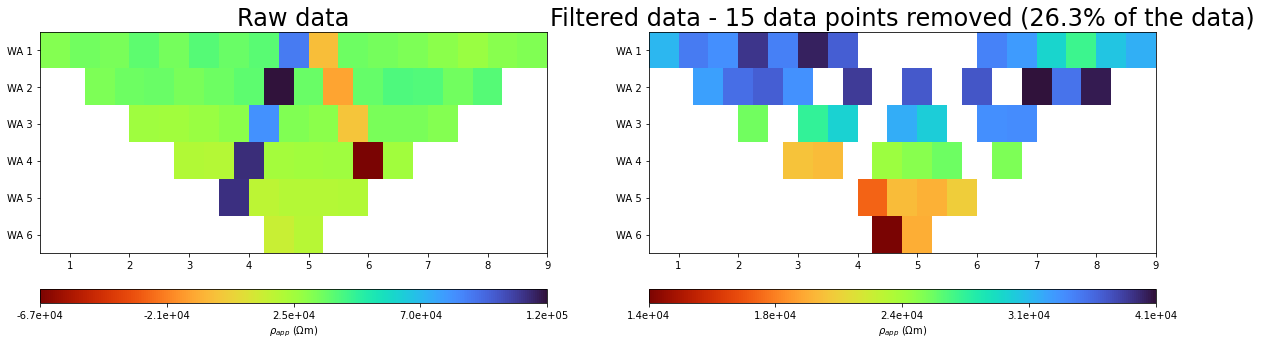

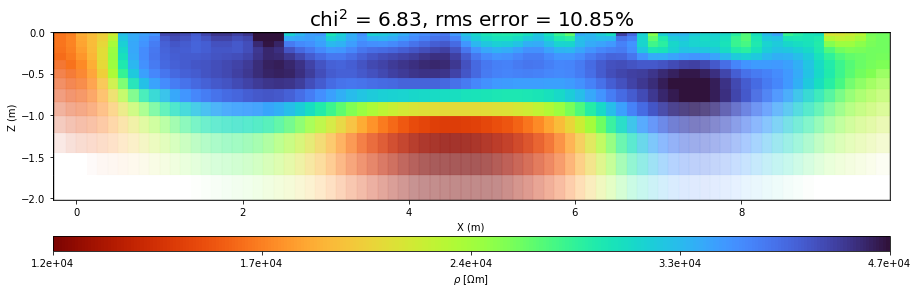

In [6]:
# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')


n_data = 57
n_header = 3
n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))

# choose some random datasets...

# import random

# n_tests = 5

# test_i = []
# for i in range(n_tests):
#     test_i.append(random.randint(0, n_surveys))
    
# test_i = np.sort(test_i)


# ... or test a couple specific datasets

test_i = [339, 543] 

# 339 has a few data points removed 
# 543 is where it crashed last time, due to too many data points removed


# make dictionary to store results

ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','used','survey_name',]) #could be more general?


for j in range(0,len(test_i)):

    data = pg.DataContainerERT()

    for k in range(0,len(E)):
        data.createSensor([E[k], 0.0]) # 2D, no topography

    cf = []
    for k in range(0,len(A)):
        cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

    for k in range(0,len(A)):
        data.createFourPointData(k, *map(int, cf[k])) 

    i = test_i[j]    
    
    filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
    data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float))
    data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
    data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
    
    grid = pg.createGrid(
        x=xlocs,
        y=ylocs,
        marker=1, 
        worldBoundaryMarker=True
    )  
    
    mgr, ert_inv,data_filt = process_ERT_data(
        data_raw = data,
        survey_name = filename,
        mesh=grid, # for unstructured mesh, can just say mesh=None
        start_model=None, # set to None for no temporal constraint
        plotdata=True,
        plotmodel=True,
        plotmisfit=False)    

    # append inverted results
    if ert_inv == None:
        pass
    else:
        
        if ert_all['rho_s']==None:
            ert_all = ert_inv 
        else:
            ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
    # append data
    if data_filt == None:
        pass
    else:
        if data_all['a']==None:
            data_all = data_filt
        else:
            data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# convert dictionaries to dataframes
if ert_all['rho_s']==None:
    pass
else:
    ert_all = pd.DataFrame.from_dict(ert_all)
    
if data_all['a']==None:
    pass
else:
    data_all = pd.DataFrame.from_dict(data_all)

## Run time-lapse inversion

In [7]:

# load data (separated into electrodes and data file for convenience)

elecs = pd.read_csv('data_AERT/craterlake_electrodes.txt', sep='\t')
data_in = pd.read_csv('data_AERT/craterlake_data_thawevent.txt',sep='\t')
# data_in = pd.read_csv('data_AERT/craterlake_data.txt',sep='\t')


n_data = 57
n_header = 3
n_lines = n_data + n_header
n_surveys = int(len(data_in)/(n_lines))


# make dictionary to store results

ert_all = dict.fromkeys(['rho_s','sens','survey_name','rms'])
data_all = dict.fromkeys(['a','b','m','n','err','u','i','k','rhoa','valid','used','survey_name',]) #could be more general?

# for i in range(0,n_surveys):
for i in range(0,20): # this is just testing the first few datasets

    data = pg.DataContainerERT()

    for k in range(0,len(E)):
        data.createSensor([E[k], 0.0]) # 2D, no topography

    cf = []
    for k in range(0,len(A)):
        cf.append([A[k]-1,B[k]-1,M[k]-1,N[k]-1])

    for k in range(0,len(A)):
        data.createFourPointData(k, *map(int, cf[k])) 
    
    filename = data_in.iloc[i*n_lines]['U0(mV)'][0:10] + ' ' + data_in.iloc[i*n_lines]['U90(mV)'][0:8] # use date and time to ID surveys
    
    data['err'] = np.array(data_in['errorU0(%)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float))
    data['u'] = np.array(data_in['U0(mV)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
    data['i'] = np.array(data_in['I(mA)'].iloc[(i*n_lines)+3:(i+1)*n_lines].astype(float)/1000)
    
    grid = pg.createGrid(
        x=xlocs,
        y=ylocs,
        marker=1, 
        worldBoundaryMarker=True
    )
    
    if ert_all['rho_s']==None: # for first iteration, run a regular inversion
        mgr, ert_inv,data_filt = process_ERT_data(
            data_raw = data,
            survey_name = filename,
            mesh=grid, # for unstructured mesh, can just say mesh=None
            start_model=None, # set to None for no temporal constraint
            plotdata=False,
            plotmodel=False,
            plotmisfit=False
        )  
        
    else: # for subsequent inversions, use time-lapse
        mgr, ert_inv,data_filt = process_ERT_data(
            data_raw = data,
            survey_name = filename,
            mesh=grid, # for unstructured mesh, can just say mesh=None
            start_model=(np.array(ert_all['rho_s'])[np.where(np.array(ert_all['survey_name'])==ert_all['survey_name'][-1])]), # set to None for no temporal constraint
            plotdata=False,
            plotmodel=False,
            plotmisfit=False
        )          
        
    # append inverted results
    if ert_inv == None:
        pass
    else:
        if ert_all['rho_s']==None:
            ert_all = ert_inv 
        else:
            ert_all = {key: ert_all[key] + ert_inv[key] for key in ert_all}
    
    # append data
    if data_filt == None:
        pass
    else:
        if data_all['a']==None:
            data_all = data_filt
        else:
            data_all = {key: data_all[key] + data_filt[key] for key in data_all}

# convert dictionaries to dataframes
if ert_all['rho_s']==None:
    pass
else:
    ert_all = pd.DataFrame.from_dict(ert_all)
    
if data_all['a']==None:
    pass
else:
    data_all = pd.DataFrame.from_dict(data_all)

27/06/22 - 19:08:11 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 45): /Users/teddiherringnew/Library/Caches/pygimli/5402275551236188304
27/06/22 - 19:08:11 - pyGIMLi - INFO - Found 1 regions.
27/06/22 - 19:08:11 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/06/22 - 19:08:11 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/22 - 19:08:11 - pyGIMLi - INFO - Use median(data values)=545123.0311452263
27/06/22 - 19:08:11 - pyGIMLi - INFO - Created startmodel from forward operator: 1120 [545123.0311452263,...,545123.0311452263]
27/06/22 - 19:08:18 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 29): /Users/teddiherringnew/Library/Caches/pygimli/7473002199343899026
27/06/22 - 19:08:18 - pyGIMLi - INFO - F

27/06/22 - 19:08:38 - pyGIMLi - INFO - Found 1 regions.
27/06/22 - 19:08:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/06/22 - 19:08:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/22 - 19:08:38 - pyGIMLi - INFO - Starting model set from given array. [143746.65226314 149723.38573811 160005.99505291 ... 363692.52832776
 380280.61391752 372695.32584555]
27/06/22 - 19:08:45 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 8): /Users/teddiherringnew/Library/Caches/pygimli/3688197146227780010
27/06/22 - 19:08:45 - pyGIMLi - INFO - Found 1 regions.
27/06/22 - 19:08:45 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/06/22 - 19:08:45 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/22 - 19:08:45 - pyGIMLi - INFO - Starting model set from given array. [188353.45149548 193431.60719783 

27/06/22 - 19:10:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/22 - 19:10:07 - pyGIMLi - INFO - Starting model set from given array. [ 97250.72504333  99078.87021964 102306.03225382 ... 282898.66636321
 269030.83479684 261862.40907151]
27/06/22 - 19:10:15 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 6): /Users/teddiherringnew/Library/Caches/pygimli/9038253802574048364
27/06/22 - 19:10:15 - pyGIMLi - INFO - Found 1 regions.
27/06/22 - 19:10:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/06/22 - 19:10:15 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/06/22 - 19:10:15 - pyGIMLi - INFO - Starting model set from given array. [ 87645.33377958  88809.59770248  90970.67137095 ... 312876.8908984
 287058.25543211 278462.31593971]
27/06/22 - 19:10:24 - pyGIMLi - INFO - Cache /Users/teddiherringnew

## Save results locally

In [8]:
ert_all.to_csv('ert_all')
data_all.to_csv('data_all')
grid.exportVTK('mesh')


## Load and plot results 

In [9]:
grid = pg.load('mesh.vtk')
ert_all = pd.read_csv('ert_all', sep=',',index_col=0)
data_all = pd.read_csv('data_all', sep=',',index_col=0)

n_surveys_proc = len(np.unique(ert_all['survey_name']))

## First, make a new column with datetime dates

In [10]:
from datetime import datetime

survey_time = []
for i in range(len(ert_all)):
    survey_time.append(datetime.strptime(ert_all['survey_name'].iloc[i], '%d.%m.%Y %H:%M:%S'))
ert_all['survey_time'] = survey_time

survey_time = []
for i in range(len(data_all)):
    survey_time.append(datetime.strptime(data_all['survey_name'].iloc[i], '%d.%m.%Y %H:%M:%S'))
data_all['survey_time'] = survey_time

### As animation

In [11]:
@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
    
    #### retrieve data from table
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = data_all[data_all['survey_time']==dates_sort[i]]
    data_in = pg.DataContainerERT()
    data_out = pg.DataContainerERT()

    for k in range(0,len(E)):
        data_in.createSensor([E[k], 0.0]) # 2D, no topography
        data_out.createSensor([E[k], 0.0]) # 2D, no topography

    cols = ['a','b','m','n','k','rhoa','k']

    for k in range(len(data_plt)):

        data_in.addFourPointData(
            [int(data_plt['a'].iloc[k]),
             int(data_plt['b'].iloc[k]),
             int(data_plt['m'].iloc[k]),
             int(data_plt['n'].iloc[k])],
            rhoa=data_plt['rhoa'].iloc[k],
            k=data_plt['k'].iloc[k],
        )

        if data_plt['used'].iloc[k] > 0:

            data_out.addFourPointData(
                [int(data_plt['a'].iloc[k]),
                 int(data_plt['b'].iloc[k]),
                 int(data_plt['m'].iloc[k]),
                 int(data_plt['n'].iloc[k])],
                rhoa=data_plt['rhoa'].iloc[k] ,
                k=data_plt['k'].iloc[k],
            )
    
    
    fig, ax = plt.subplots(1,2,figsize=[20,5])

    pg.physics.ert.showData(
        data_in, 
        vals=data_in['rhoa'],
        ax=ax[0],
        label=r'$\rho_{app}$ ($\Omega$m)',
        cMap='turbo_r',
        cMin=1e5,
        cMax=1e6,
        logScale=True
    );
    
    ax[0].set_title('Raw data',fontsize=24);

    if sum(data_plt['used'])/len(data_plt)<0.3:
        txt = 'Poor quality dataset - too many points filtered'
        ax[1].text(0.05,0.5,txt,fontsize=20)
        
    else:
        pg.physics.ert.showData(
            data_out, 
            vals=data_out['rhoa'],
            ax=ax[1],
            label=r'$\rho_{app}$ ($\Omega$m)',
            cMap='turbo_r',
            cMin=1e5,
            cMax=1e6,
            logScale=True
        );
        
        ax[1].set_title('Filtered data - %.0f data points removed (%.1f%% of the data)'%(data_in.size()-data_out.size(), float((data_in.size()-data_out.size())/data_in.size()*100)),fontsize=24);


    
    #### plot model
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])
    
    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
        
    else:

        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=1e5, # set the colorbar min/max here
            cMax=1e6,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);


    
    


interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

## Plot resistivity from a specific point location over time

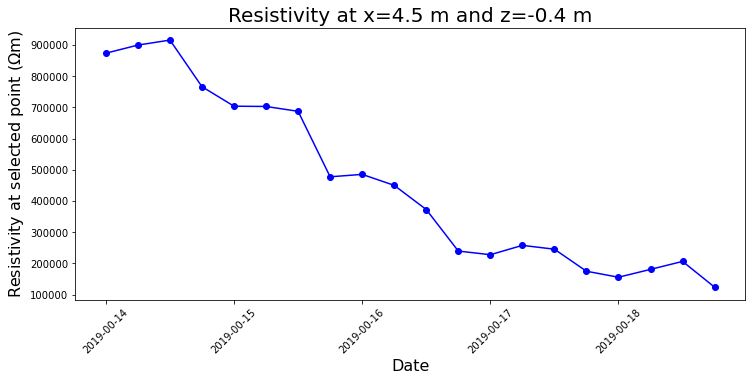

In [12]:
# enter the coordinates where you'd like to get resistivity from:

x_pos = 4.5
z_pos = -0.4

# find the closest model cell

xi = np.where(abs(np.array(grid.cellCenters()).T[0]-x_pos)==min(abs(np.array(grid.cellCenters()).T[0]-x_pos)))
zi = np.where(abs(np.array(grid.cellCenters()).T[1]-z_pos)==min(abs(np.array(grid.cellCenters()).T[1]-z_pos)))

cell_point = np.intersect1d(xi, zi)[0]

# for get date/resistivity pairs for plotting

dt = []
rho_point = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
for i in range(n_surveys_proc):
    
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    if data_plt['rho_s'].iloc[0]==-999:
        rho_point.append(np.nan)
    else:
        rho_point.append(data_plt['rho_s'].iloc[cell_point])
    
    
# plot the results

fig, ax = plt.subplots(1,1,figsize=[12,5])
plt.plot_date(dt, rho_point,'bo-')

import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y-%M-%d') 
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45);
plt.xlabel('Date',fontsize=16)
plt.ylabel(r'Resistivity at selected point ($\Omega$m)',fontsize=16)
plt.title('Resistivity at x=%.1f m and z=%.1f m'%(x_pos,z_pos),fontsize=20);

### Show point on graph

In [13]:
@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
#     dates = np.unique(ert_all['survey_name'])
#     dates_sort = sorted(dates, key=lambda x: (x[6:10],x[3:5],x[0:2],x[11:13]))
#     data_plt = ert_all[ert_all['survey_name']==dates_sort[i]]
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])

    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
    else:
        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=1e5, # set the colorbar min/max here
            cMax=1e6,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);

        ax.plot(np.array(grid.cellCenters()).T[0][cell_point],np.array(grid.cellCenters()).T[1][cell_point],'kx',markersize=10)


interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

## Plot average* resistivity from a specific rectangular region over time

 Right now this is just an average.
 If you want to get fancy, you could try weighting the values by their respective cell volumes

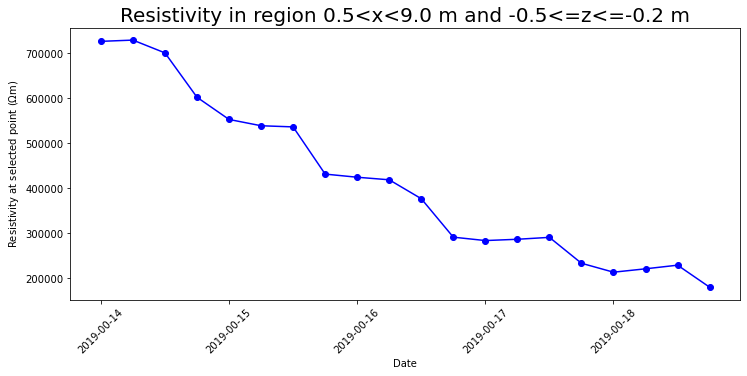

In [14]:
# enter the coordinates where you'd like to get resistivity from:

xmin = 0.5
xmax = 9
zmin = -0.5
zmax = -0.2

# find all cells within region

xi = np.where(np.logical_and(np.array(grid.cellCenters()).T[0]>=xmin,np.array(grid.cellCenters()).T[0]<=xmax))
zi = np.where(np.logical_and(np.array(grid.cellCenters()).T[1]>=zmin,np.array(grid.cellCenters()).T[1]<=zmax))

cells_region = np.intersect1d(xi, zi)

# for get date/resistivity pairs for plotting

dt = []
rho_region = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
for i in range(n_surveys_proc):
    
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    
    if data_plt['rho_s'].iloc[0]==-999:
        rho_region.append(np.nan)
    else:   
        rho_region.append(np.mean(data_plt['rho_s'].iloc[cells_region]))
    
    
# plot the results

fig, ax = plt.subplots(1,1,figsize=[12,5])
plt.plot_date(dt, rho_region,'bo-')

import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y-%M-%d') 
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45);
plt.xlabel('Date')
plt.ylabel(r'Resistivity at selected point ($\Omega$m)');
plt.title('Resistivity in region %.1f<x<%.1f m and %.1f<=z<=%.1f m'%(xmin,xmax,zmin,zmax),fontsize=20);

In [15]:
from ipywidgets import interact
import matplotlib.patches as patches

@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
#     dates = np.unique(ert_all['survey_name'])
#     dates_sort = sorted(dates, key=lambda x: (x[6:10],x[3:5],x[0:2],x[11:13]))
#     data_plt = ert_all[ert_all['survey_name']==dates_sort[i]]
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])

    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
    else:
        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=1e5, # set the colorbar min/max here
            cMax=1e6,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);

    #     ax.plot(np.array(grid.cellCenters()).T[0][cells_region],np.array(grid.cellCenters()).T[1][cells_region],'kx',markersize=10)
        rect = patches.Rectangle([xmin,zmin],xmax-xmin,zmax-zmin,edgecolor='k',fill=False)
        ax.add_patch(rect)

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

## Plot resistivity at a virtual borehole

note: borehole at x=4.4 m (closest grid cells to desired x position)


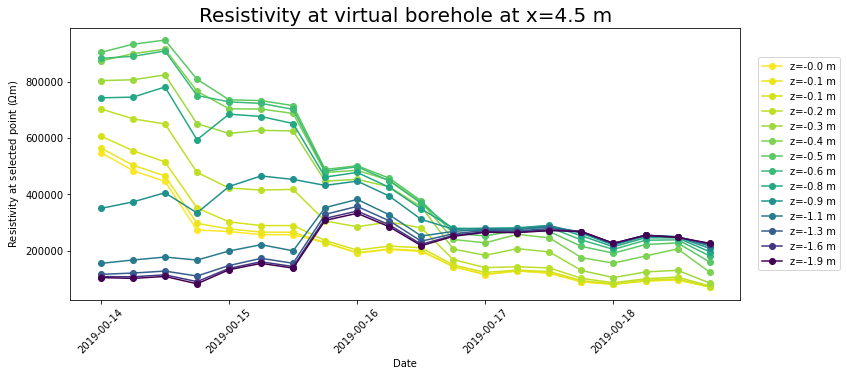

In [16]:
# enter the coordinates where you'd like to get resistivity from:

xborehole = 4.49

# find all cells within region

cells_borehole  = np.where(abs(np.array(grid.cellCenters()).T[0]-xborehole)==min(abs(np.array(grid.cellCenters()).T[0]-xborehole)))

# for get date/resistivity pairs for plotting

dt = []
rho_borehole = []
z_borehole = []

dates_sort = np.sort(np.unique(ert_all['survey_time']))
    
for i in range(n_surveys_proc):
    
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    dt.append(data_plt['survey_time'].iloc[0])
    z_borehole.append(np.flipud(np.array(grid.cellCenters()).T[1][cells_borehole]))
    
    if data_plt['rho_s'].iloc[0]==-999:
        ph = np.empty(len(cells_borehole[0]))
        ph[:] = np.nan
        rho_borehole.append(ph)
    else:
        rho_borehole.append(np.flipud(np.array(data_plt['rho_s'].iloc[cells_borehole])))
    
    
# plot the results

fig, ax = plt.subplots(1,1,figsize=[12,5])

norm = plt.Normalize(min(z_borehole[0]), max(z_borehole[0]))
cm = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)

for i in range(len(z_borehole[0])):
    plt.plot_date(dt, np.array(rho_borehole).T[i],'o-',color=cm(norm(z_borehole[0][i])),label='z=%.1f m'%z_borehole[0][i])

import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y-%M-%d') 
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45);
plt.xlabel('Date')
plt.ylabel(r'Resistivity at selected point ($\Omega$m)');
plt.title('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=20);
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5));

x_bh = np.array(grid.cellCenters()).T[0][cells_borehole][0] # true borehole location
print('note: borehole at x=%.1f m (closest grid cells to desired x position)'%x_bh)

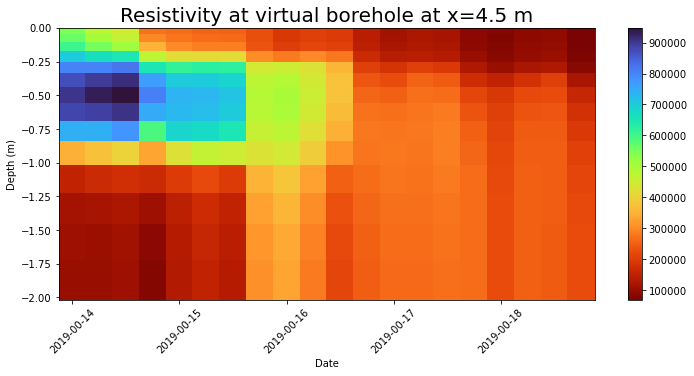

In [17]:
fig, ax = plt.subplots(1,1,figsize=[12,5])
X, Y = np.meshgrid(dt,z_borehole[0])
plt.pcolormesh(X,Y,np.array(rho_borehole).T,cmap='turbo_r',shading='auto')

import matplotlib.dates as mdates
date_format = mdates.DateFormatter('%Y-%M-%d') 
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=45)
plt.colorbar()
plt.xlabel('Date')
plt.ylabel('Depth (m)')
plt.title('Resistivity at virtual borehole at x=%.1f m'%(xborehole),fontsize=20);


In [18]:
from ipywidgets import interact
import matplotlib.patches as patches

@interact(i=(0,n_surveys_proc-1))

def plot_m(i=0):
    
#     dates = np.unique(ert_all['survey_name'])
#     dates_sort = sorted(dates, key=lambda x: (x[6:10],x[3:5],x[0:2],x[11:13]))
#     data_plt = ert_all[ert_all['survey_name']==dates_sort[i]]
    
    dates_sort = np.sort(np.unique(ert_all['survey_time']))
    data_plt = ert_all[ert_all['survey_time']==dates_sort[i]]
    
    fig, ax = plt.subplots(1,1,figsize=[15,5])

    if data_plt['rho_s'].iloc[0]==-999:
        txt = 'Poor quality dataset - inversion not performed'
        ax.text(0.2,0.5,txt,fontsize=20)
    else:
        
        cax, cBar = pg.show(
            grid,
            pg.core.RVector(np.array(data_plt['rho_s'])),
            ax=ax,
            cMap='turbo_r',
            coverage=data_plt['sens'],
            cMin=1e5, # set the colorbar min/max here
            cMax=1e6,
            logScale=True

        );

        cBar.set_label(r'$\rho$ [$\Omega$m]')

        ax.set_xlim([min(E),max(E)])
        ax.set_ylim([ax.get_ylim()[0],0.3])
        ax.plot(E,np.zeros(len(E))+0.1,'kv')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        ax.set_title(r'%s, rms error = %.2f%%'%(data_plt['survey_name'].iloc[0],data_plt['rms'].iloc[0]),fontsize=20);

        x_bh = np.array(grid.cellCenters()).T[0][cells_borehole][0] # true borehole location
        ax.plot([x_bh,x_bh],[0,-2],'k')

        print('note: borehole at x=%.1f m (closest grid cells to desired x position)'%x_bh)

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…